# Processing Satellite Images with XArray

The tutorial shows how to take satellite data from widely used sensors and process it using XArray. This tutorial uses data downloaded from the providers and the methods shown is suitable for uses in **offline environments** or when cloud-hosted datasets cannot be used.

> For cloud-based processing of satellite images, see our full course [Scalable Remote Sensing Workflows with Xarray](https://courses.spatialthoughts.com/python-remote-sensing.html)

> For processing of ResourceSat-2/2A data, see our detailed post [LISS4 Image Processing using XArray and Dask
](https://spatialthoughts.com/2023/12/25/liss4-processing-xarray/).

The tutorial is divided into 2 parts showing how to work with Sentinel-2 and Landsat-8 scenes.


## Part-1: Processing Sentinel-2 L1C Data

In this section, we will take a single Sentinel-2 L1C scene and learn how to read it using XArray, visualize it and compute spectral indices.

**Input Layers**:
* `S2A_MSIL1C_20230212T050931_N0509_R019_T43PGQ_20230212T065641.SAFE.zip`: A Sentinel-2 L1C scene downloaded from the [Copernicus Browser](https://dataspace.copernicus.eu/).
* `bangalore.geojson`: A GeoJSON file representing the municipal boundary for the city of Bengaluru, India.

**Output**:
* `clipped.tif`, `ndvi.tif`, `mndwi.tif`, `savi.tif`: RGB composite and spectral indices calculated from Sentinel-2.

**Data Credit**:
* Bangalore Ward Maps Provided by Spatial Data of Municipalities (Maps) Project by Data{Meet}.
* Sentinel-2 Level 2A Scenes: Contains modified Copernicus Sentinel data (2025-02)

### Setup and Data Download

The following blocks of code will install the required packages and download the datasets to your Colab environment.

In [ ]:
%%capture
if 'google.colab' in str(get_ipython()):
  !pip install rioxarray

In [ ]:
import os
import matplotlib.pyplot as plt
import xarray as xr
import rioxarray as rxr
import zipfile
import geopandas as gpd

In [ ]:
from dask.distributed import Client
client = Client()  # set up local cluster on the machine
client

If you are running this notebook in Colab, you will need to create and use a proxy URL to see the dashboard running on the local server.

In [ ]:
if 'google.colab' in str(get_ipython()):
    from google.colab import output
    port_to_expose = 8787  # This is the default port for Dask dashboard
    print(output.eval_js(f'google.colab.kernel.proxyPort({port_to_expose})'))

In [ ]:
data_folder = 'data'
output_folder = 'output'

if not os.path.exists(data_folder):
    os.mkdir(data_folder)
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

In [ ]:
def download(url):
    filename = os.path.join(data_folder, os.path.basename(url))
    if not os.path.exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

s2_scene = 'S2A_MSIL1C_20230212T050931_N0509_R019_T43PGQ_20230212T065641.SAFE.zip'
data_url = 'https://github.com/spatialthoughts/geopython-tutorials/releases/download/data/'
download(data_url + s2_scene)

aoi = 'bangalore.geojson'
download(data_url + aoi)


### Data Pre-Processing

We first unzip the zip archive and create a XArray Dataset from the individual band images.


In [ ]:
s2_filepath = os.path.join(data_folder, s2_scene)

with zipfile.ZipFile(s2_filepath) as zf:
  zf.extractall(data_folder)

Sentinel-2 images come as individual JPEG2000 rasters for each band. The image files are located in the `GRANULE/{SCENE_ID}/IMG_DATA/` subfolder. We find the files and read them using `rioxarray`.

In [ ]:
import glob
s2_folder = s2_filepath[:-4]

band_files = {}

for filepath in glob.glob(
    os.path.join(s2_folder, 'GRANULE', '*', 'IMG_DATA', '*B*.jp2')):
  filename = os.path.basename(filepath)
  # Extract the part of the filename containing band name such as 'B01'
  band_name = os.path.splitext(filename)[0].split('_')[-1]
  band_files[band_name] = filepath

band_files

Different Sentinel-2 bands have different spatial resolutions. To put them in the same array, their dimensions must match. So we combine bands of similar resolutions and resample others to match them.

* B04, B03, B02 and B08 = 10m
* B12, B11, B07, B06, B05 and B08A = 20m
* B10, B09, B1 = 60m

In [ ]:
b4 = rxr.open_rasterio(band_files['B04'], chunks=True)
b3 = rxr.open_rasterio(band_files['B03'], chunks=True)
b2 = rxr.open_rasterio(band_files['B02'], chunks=True)
b8 = rxr.open_rasterio(band_files['B08'], chunks=True)

stack1 = xr.concat([b4, b3, b2, b8], dim='band').assign_coords(
    band=['B04', 'B03', 'B02', 'B08'])

In [ ]:
b5 = rxr.open_rasterio(band_files['B05'], chunks=True)
b6 = rxr.open_rasterio(band_files['B07'], chunks=True)
b7= rxr.open_rasterio(band_files['B07'], chunks=True)
b8a = rxr.open_rasterio(band_files['B8A'], chunks=True)
b11 = rxr.open_rasterio(band_files['B11'], chunks=True)
b12 = rxr.open_rasterio(band_files['B12'], chunks=True)

stack2 = xr.concat([b5, b6, b7, b8a, b11, b12], dim='band').assign_coords(
    band=['B05', 'B06', 'B07', 'B8A', 'B11', 'B12'])

Now we reproject the bands to match the resolution of the 10m bands using `reproject_match()`

In [ ]:
stack2 = stack2.rio.reproject_match(stack1)

Both band stacks now have the same resolution and hence the same X and Y dimensions. We can now combine them across the `band` dimension. The Sentinel-2 scenes come with NoData value of 0. So we set the correct NoData value before further processing.

In [ ]:
scene = xr.concat([stack1, stack2], dim='band')
scene = scene.where(scene != 0)
scene

We will clip the scene to the geometry of the GeoJSON file. We must ensure that the projection of the GeoDataFrame and the XArray DataArray match.

In [ ]:
aoi_path = os.path.join(data_folder, aoi)
aoi_gdf = gpd.read_file(aoi_path)
geometry = aoi_gdf.to_crs(scene.rio.crs).geometry
clipped = scene.rio.clip(geometry)
clipped

Sentinel-2 pixel values need to be converted to reflectances using the following formula:

`ρ   =  (L1C_DN + RADIO_ADD_OFFSET) / QUANTIFICATION_VALUE`

`QUANTIFICATION_VALUE` for all S2 scenes is **10000** and starting from January 22,2023, all new scenes have a `RADIO_ADD_OFFSET` of **-1000**



In [ ]:
scaled = (clipped - 1000)/10000

We can now apply all the operations and compute the result via Dask. This will load the resulting array into memory.

In [ ]:
%%time
scaled = scaled.compute()

### Visualization

We can visualize a 3-band composite image.

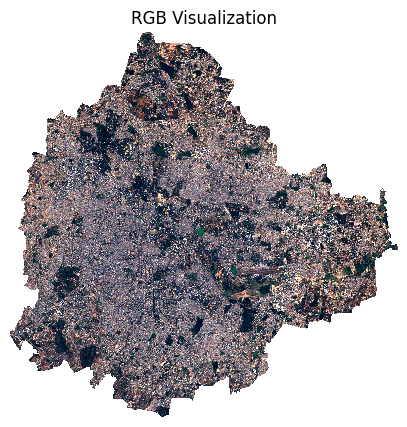

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5,5)
scaled.sel(band=['B04', 'B03', 'B02']).plot.imshow(
    ax=ax,
    robust=True)
ax.set_title('RGB Visualization')
ax.set_axis_off()
plt.show()

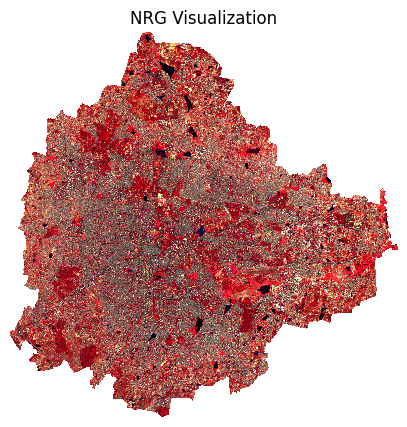

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5,5)
scaled.sel(band=['B08', 'B04', 'B03']).plot.imshow(
    ax=ax,
    robust=True)
ax.set_title('NRG Visualization')
ax.set_axis_off()
plt.show()

### Calculating Indices

In [ ]:
red = scaled.sel(band='B04')
nir = scaled.sel(band='B08')

ndvi = (nir - red)/(nir + red)

Let's visualize the results.

In [ ]:
cbar_kwargs = {
    'orientation':'horizontal',
    'fraction': 0.025,
    'pad': 0.05,
    'extend':'neither'
}

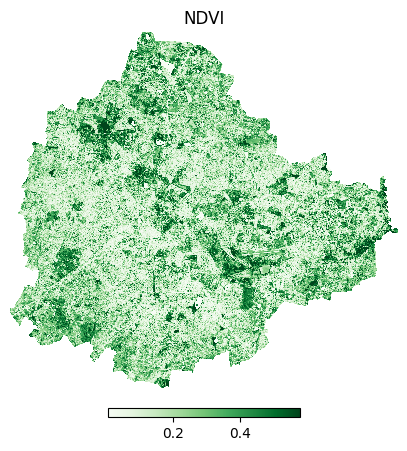

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5,5)
ndvi.plot.imshow(
    ax=ax,
    cmap='Greens',
    robust=True,
    cbar_kwargs=cbar_kwargs)
ax.set_title('NDVI')
ax.set_axis_off()
plt.show()

In [ ]:
green = scaled.sel(band='B03')
swir1 = scaled.sel(band='B11')

mndwi = (green - swir1)/(green + swir1)

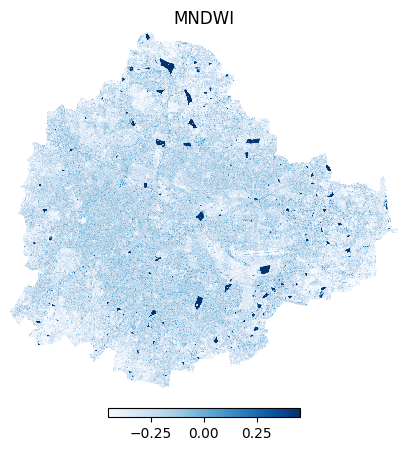

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5,5)
mndwi.plot.imshow(
    ax=ax,
    cmap='Blues',
    robust=True,
    cbar_kwargs=cbar_kwargs)
ax.set_title('MNDWI')
ax.set_axis_off()
plt.show()

In [ ]:
red = scaled.sel(band='B04')
nir = scaled.sel(band='B08')

savi = 1.5 * ((nir - red) / (nir + red + 0.5))

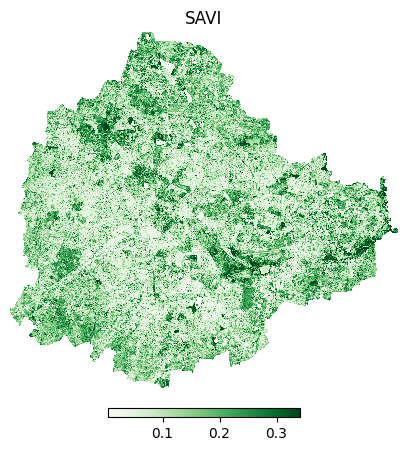

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5,5)
savi.plot.imshow(
    ax=ax,
    cmap='Greens',
    robust=True,
    cbar_kwargs=cbar_kwargs)
ax.set_title('SAVI')
ax.set_axis_off()
plt.show()

### Saving the results

In [ ]:
files = {
    'clipped.tif': scaled,
    'ndvi.tif': ndvi,
    'mndwi.tif': mndwi,
    'savi.tif': savi
}

for file in files:
  output_path = os.path.join(output_folder, file)
  files[file].rio.to_raster(output_path, driver='COG')


## Part-2: Processing Landsat-8 Data

In this section, we will take a single Landsat 8 scene and learn how to read it using XArray, visualize it and mask clouds.

**Input Layers**:
* `LC08_L2SP_144052_20190209_20200829_02_T1.zip`: A Landsat 8 scene downloaded from the [USGS EarthExplorer](https://earthexplorer.usgs.gov/).

**Output Layers**:
* `landsat_masked.tif`: Cloud-masked RGB composite of Landsat-8.

**Data Credit**:
* Landsat-8 image courtesy of the U.S. Geological Survey


### Setup and Data Download

In [ ]:
import os
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import xarray as xr
import rioxarray as rxr
import zipfile
import numpy as np

In [ ]:
data_folder = 'data'
output_folder = 'output'

if not os.path.exists(data_folder):
    os.mkdir(data_folder)
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

In [ ]:
def download(url):
    filename = os.path.join(data_folder, os.path.basename(url))
    if not os.path.exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
landsat_scene = 'LC08_L2SP_144052_20190209_20200829_02_T1.zip'

data_url = 'https://github.com/spatialthoughts/geopython-tutorials/releases/download/data/'
download(data_url + landsat_scene)


### Data Pre-Processing

We first unzip the zip archive and create a XArray Dataset from the individual band images.



In [ ]:
landsat_filepath = os.path.join(data_folder, landsat_scene)

with zipfile.ZipFile(landsat_filepath) as zf:
  zf.extractall(data_folder)

Sentinel-2 images come as individual GeoTIFF rasters for each band. The image band files cotaining data from the OLI sensor are named such as `*_SR_B1.TIF`, `*_SR_B2.TIF` etc. We find the files and read them using `rioxarray`.

In [ ]:
import glob

band_files = {}

for filepath in glob.glob(
    os.path.join(data_folder, '*SR_B*.TIF')):
  filename = os.path.basename(filepath)
  # Extract the part of the filename containing band name such as 'B01'
  band_name = os.path.splitext(filename)[0].split('_')[-1]
  band_files[band_name] = filepath

band_files

We read the bands using `rioxarray` and combine them into a single DataArray.

In [ ]:
bands = []

for band_name, band_path in band_files.items():
  ds = rxr.open_rasterio(band_path, chunks=True, masked=True)
  ds.name = band_name
  bands.append(ds)

scene = xr.concat(bands, dim='band').assign_coords(
    band=list(band_files.keys()))
scene

Landsat Collection 2 surface reflectance has a scale factor of `0.0000275` and an additional offset of `-0.2` per pixel. We apply the scale and offset to get the reflectance values



In [ ]:
landsat_scaled = (scene*0.0000275) - 0.2

### Visualization

We can visualize a low-resolution preview of the 3-band composite image.

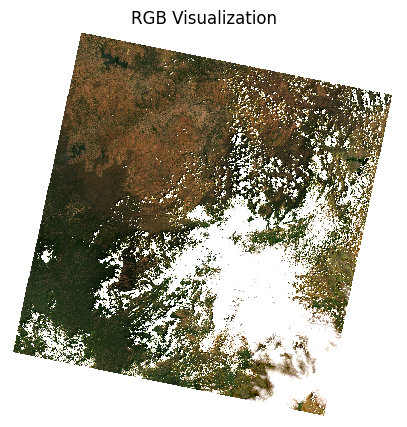

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5,5)
# Resample the scene to a lower resolution for visualization
preview = landsat_scaled.sel(band=['B4', 'B3', 'B2']).rio.reproject(
    landsat_scaled.rio.crs, resolution=300)

preview.plot.imshow(
    ax=ax,
    vmin=0, vmax=0.3)
ax.set_title('RGB Visualization')
ax.set_axis_off()
plt.show()

### Applying a Cloud Mask

Most satellite providers store pixel quality information as bitmasks. This allows the providers to store a lot more information in an efficient way. Bitmasks can be hard to understand. Please read our post on [Working with QA Bands and Bitmasks in Google Earth Engine
](https://spatialthoughts.com/2021/08/19/qa-bands-bitmasks-gee/) to understand the concepts. Here we apply the same concept using a Python implementation of bitmasking adapted from Google Earth Engine.

Read the QA band which comes with a filename ending with `*QA_PIXEL.TIF`.

In [ ]:
for qa_filepath in glob.glob(
    os.path.join(data_folder, '*QA_PIXEL.TIF')):
  break

pixel_qa = rxr.open_rasterio(qa_filepath, chunks=True, masked=True)
pixel_qa.name = 'pixel_qa'
pixel_qa

In [ ]:
pixel_qa = pixel_qa.squeeze().astype('int64')
pixel_qa

The 16-bit pixel value is determined by setting each of the bits to 0 or 1.

Since we are interested in clouds, the first 5 bits are relevant

| Bit | Description  |
| --- | ------------ |
| 0   | Fill         |
| 1   | Dilated Cloud|
| 2   | Cirrus       |
| 3   | Cloud        |
| 4   | Cloud Shadow |

We create a mask using the `np.bitwise_and()` function against the binary number `11111`. The result will be 0 only if all the bits are set to 0 indicating clear conditions.

In [ ]:
mask = xr.full_like(pixel_qa, int('11111', 2))
qa_mask = np.bitwise_and(pixel_qa, mask) == (0)
qa_mask

In [ ]:
scene_masked = landsat_scaled.where(qa_mask)
scene_masked

Plot a low-resolution preview.

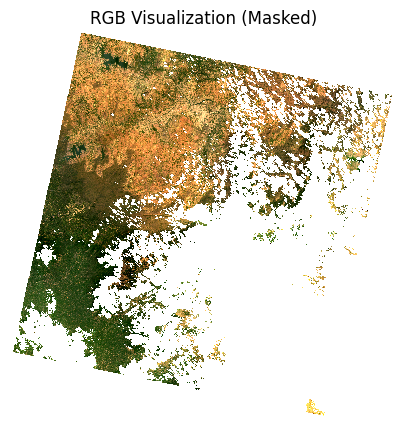

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5,5)
# Resample the scene to a lower resolution for visualization
scene_masked_preview = scene_masked.sel(band=['B4', 'B3', 'B2']).rio.reproject(
    scene_masked.rio.crs, resolution=300
)

scene_masked_preview.plot.imshow(
    ax=ax,
    robust=True)
ax.set_title('RGB Visualization (Masked)')
ax.set_axis_off()
plt.show()

Let's write the resulting masked as a multi-band GeoTIFF file using rioxarray. We convert the DataArray to a DataSet with each band being a separate variable. This results in a much nicer GeoTIFF that is compatible with desktop software.



In [ ]:
output_file = 'landsat_masked.tif'
output_path = os.path.join(output_folder, output_file)

output_ds = scene_masked.to_dataset('band')
output_ds[['B4', 'B3', 'B2']].rio.to_raster(output_path, compress='deflate')

----

If you want to give feedback or share your experience with this tutorial, please comment below. (requires GitHub account)


<script src='https://utteranc.es/client.js'
    repo='spatialthoughts/geopython-tutorials'
    issue-term='pathname'
    theme='github-light'
    crossorigin='anonymous'
    async>
</script>